In [35]:
#pip install statsmodels

In [36]:
#pip install pmdarima


In [37]:
import pandas as pd
pd.options.mode.chained_assignment = None #remove warning masseges from panda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationary test
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA #this package doesn't work anymore and was switched to the one underneth
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima

In [38]:
POS = pd.read_csv('C:/Users/althy/Desktop/Final_Graduation_Project-main/POS_monthly_2023.csv',index_col='Date', parse_dates=True)

In [39]:
POS = pd.DataFrame(POS)

<h4> Exploring and cleaning Data

In [40]:
#chose a random sample
POS.sample(5, random_state=0)

,Total
Date,
Mar-17,55266126.0
Feb-22,496263284.0
Mar-15,32793427.0
Aug-19,138025343.0
Sep-20,291969968.0


In [41]:
POS.describe()

,Total
count,9.700000e+01
mean,2.088249e+08
std,2.062546e+08
min,2.960320e+07
25%,5.215320e+07
50%,1.063572e+08
75%,3.465955e+08
max,6.919239e+08


In [42]:
#checking for Nan values
POS.isna().values.any()

True

In [43]:
POS[POS.index.isna()]

,Total
Date,


seeing the NaN rows we can conclude that they are a mistake, so we can remove them

In [44]:
clean_POS = POS.dropna()

In [45]:
#checking for duplicated in date column.
clean_POS.index.duplicated().any()

False

C:\Users\althy\AppData\Local\Temp\ipykernel_36652\1831857011.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.lineplot(x="Date", y="Total",


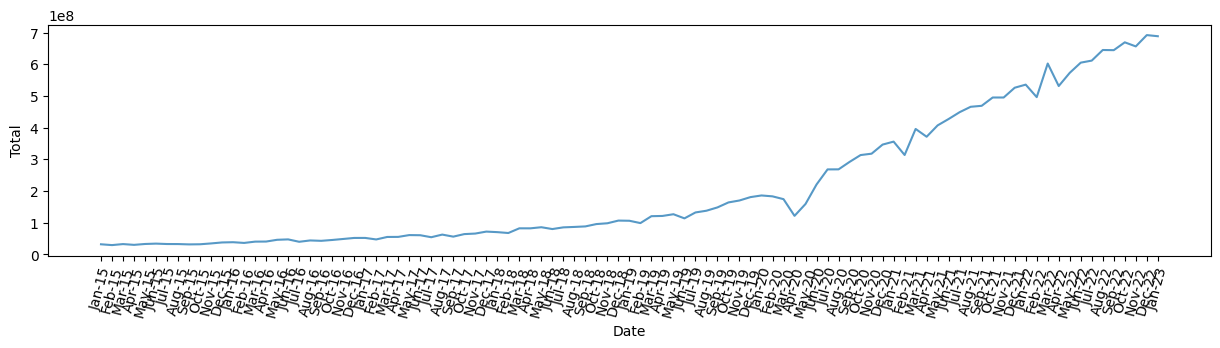

In [47]:
#making line plot 
plt.xticks(rotation=75)
fig = plt.gcf()
fig.set_size_inches(15, 3)
scatter = sns.lineplot(x="Date", y="Total", 
                          sizes=(40, 800), alpha=0.75, palette="BrBG", legend=False,
                          data=clean_POS)
# Save plot as image file
plt.savefig('line_plot.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\althy\AppData\Local\Temp\ipykernel_36652\1474480962.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.lineplot(x=clean_POS.index, y="Total",


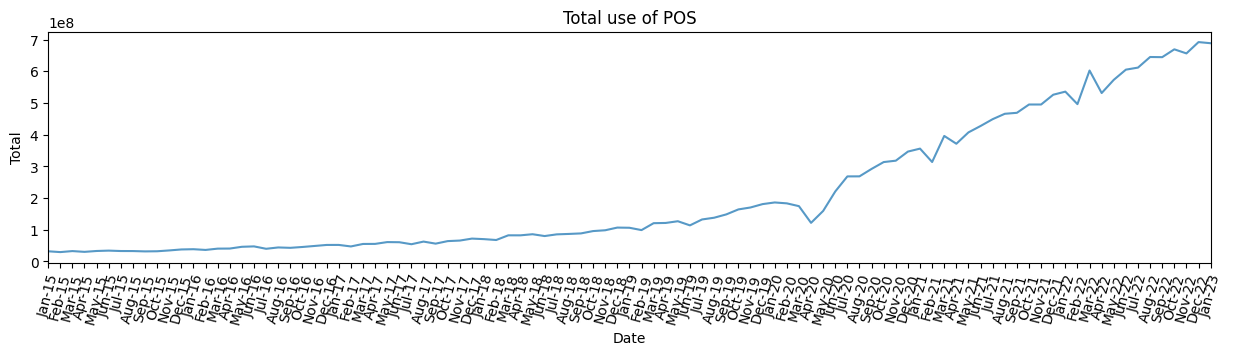

In [48]:
plt.xticks(rotation=75)
fig = plt.gcf()
fig.set_size_inches(15, 3)

# Create line plot with seaborn
scatter = sns.lineplot(x=clean_POS.index, y="Total", 
                          sizes=(40, 800), alpha=0.75, palette="BrBG", legend=False,
                          data=clean_POS)
# Set x-axis limits to start from the first date in the data
scatter.set(xlim=(clean_POS.index[0], clean_POS.index[-1]))
plt.title('Total use of POS')
# Save plot as image file
plt.savefig('line_plot.png', dpi=300, bbox_inches='tight')

# Show plot (optional)
plt.show()

<h3> Testing stationary

In [49]:
#function to test statonarity using Dickey-fuller test and ploting it 
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
  
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    #Plot rolling statistics
    fig = plt.gcf()
    fig.set_size_inches(15, 3)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.xticks(rotation=75)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Results of Dickey Fuller Test:
Test Statistic                 -0.420112
p-value                         0.906686
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


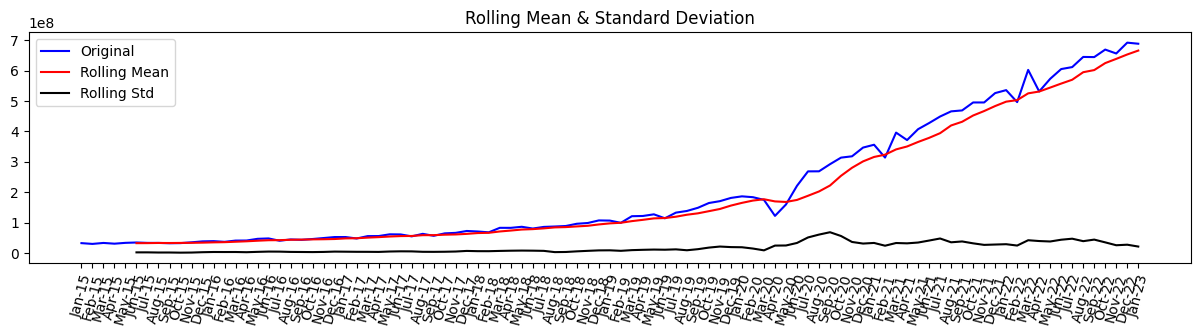

In [50]:
test_stationarity(clean_POS)

<h4> since p-value > 0.05 it's not stationary
so we will try transforming it with taking the first difference

Results of Dickey Fuller Test:
Test Statistic                 -1.188642
p-value                         0.678463
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


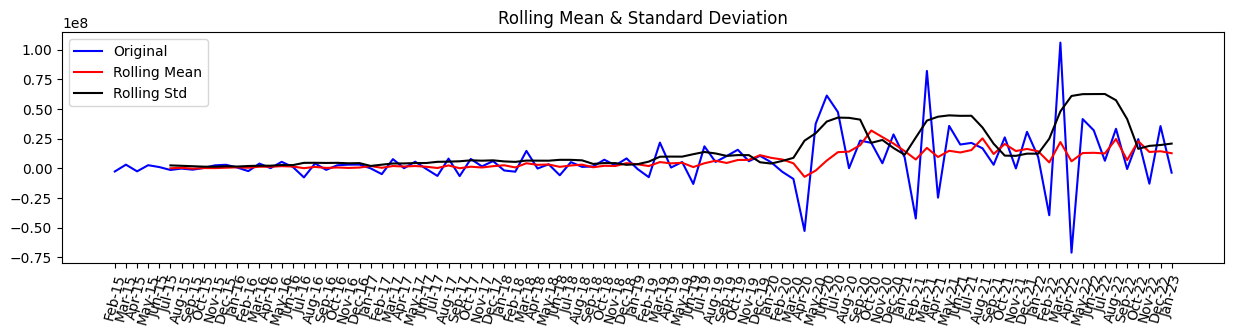

In [51]:
test_stationarity(clean_POS.diff().dropna())

<h5> p-value still high, so we will transform the data again by taking the log <h5>

Results of Dickey Fuller Test:
Test Statistic                 -5.104558
p-value                         0.000014
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


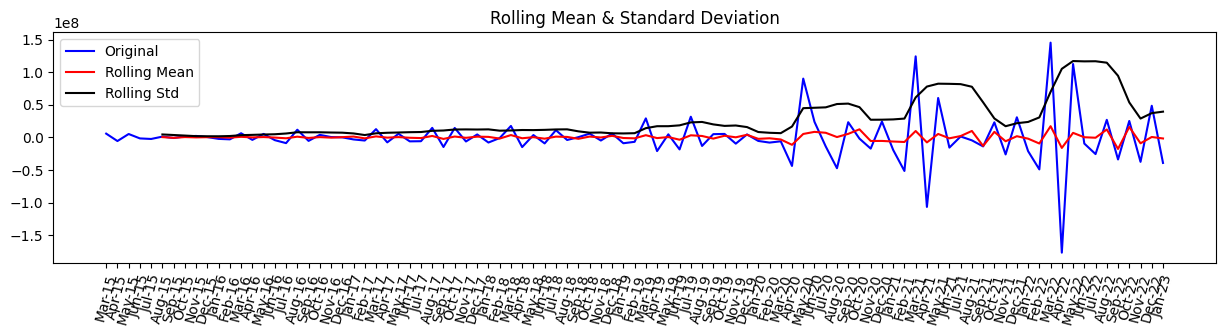

In [52]:
test_stationarity(clean_POS.diff().diff().dropna())

<h4> since the data got stationary after the seconed diffrence, then the d in ARIMA(p,d,q) is equal to 2

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


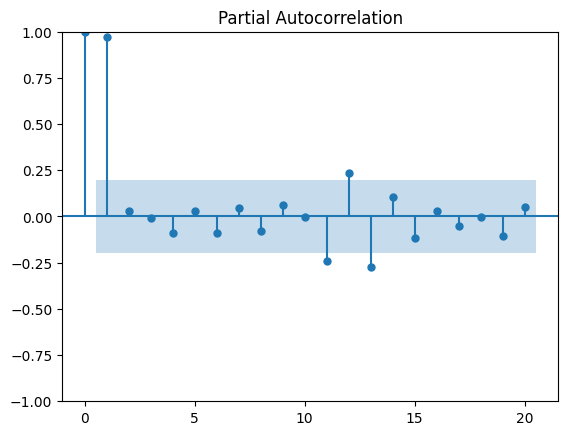

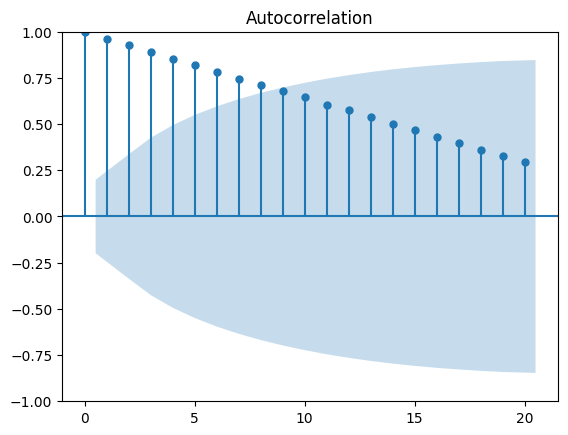

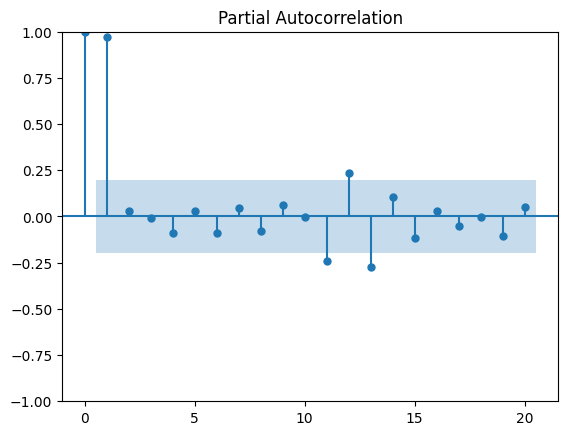

In [53]:
plot_acf(clean_POS)
plot_pacf(clean_POS)

In [54]:
#function to compare models using AIC and BIC scores
def assess_arima(model):
    AIC = model.aic
    BIC = model.bic
    KPI = {
        'AIC':AIC,
        'BIC':BIC,
        }   
    for key in KPI:
        print(key, '=', KPI[key])

<h3> since autocorrelation decay to zero, and partial autocorrelation cuts off after the 2nd itme lag, the model is ARIMA(0,2,2)

In [55]:
print(ARIMA(clean_POS, order=(0,2,2)).fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1735.947
Date:                Sun, 02 Apr 2023   AIC                           3477.893
Time:                        05:00:02   BIC                           3485.555
Sample:                             0   HQIC                          3480.989
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4228      0.087    -16.387      0.000      -1.593      -1.253
ma.L2          0.4819      0.077      6.288      0.000       0.332       0.632
sigma2      6.206e+14        nan        nan        n

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [56]:
#print(ARIMA(clean_POS, order=(1,2,1)).fit().summary())

<h5> from the result we find that ARIMA(0,2,2) has lowest AIC and BIC, now I'll split the data into train/test

In [57]:
#function that shows mae, mape, mse and rmse between test data and predicted data
def KPI(test_data,y_pred):
    mae = mean_absolute_error(y_true=test_data, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=test_data, y_pred=y_pred)
    mse = mean_squared_error(y_true=test_data, y_pred=y_pred)
    rmse = np.sqrt(mse)
    #corr = np.corrcoef(y_pred.Total, test_data.Total)
    KPI = {
        'mape':mape,
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        #'corr':corr
    }   
    for key in KPI:
        print(key, '=', KPI[key])

In [58]:
split_index = int(0.80 * len(clean_POS))
train_data = clean_POS.iloc[:split_index, :]
test_data = clean_POS.iloc[split_index:, :]


In [59]:
model = ARIMA(train_data, order=(0,2,2)).fit()
y_pred = pd.DataFrame(index= test_data.index)
y_pred['Total'] = model.forecast(len(test_data)).values

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


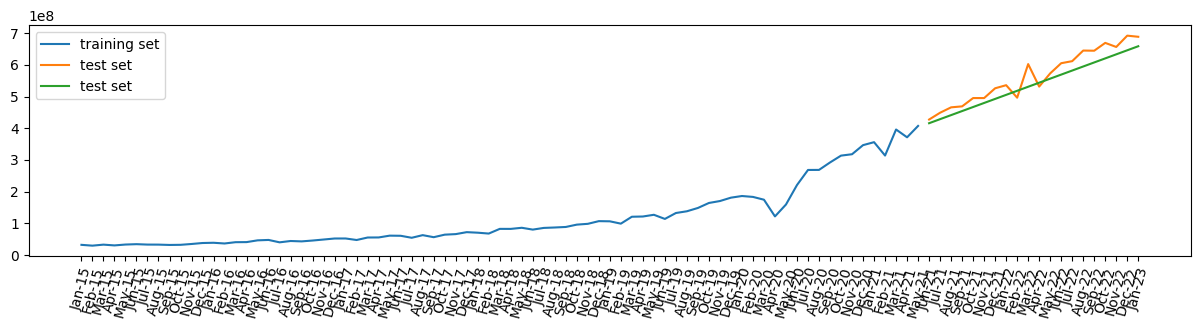

In [60]:
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.plot(train_data.dropna(), label = 'training set')
plt.plot(test_data.dropna(), label='test set')
plt.plot(y_pred, label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

In [61]:
KPI(test_data=test_data,y_pred=y_pred)

mape = 0.05206529737946378
mae = 30086577.166925192
mse = 1123490979632695.6
rmse = 33518516.96648728


<h4> from the result of mse,mape,mae and rmse, we conclude that our origingl model ARIMA(1,2,1) is better

In [62]:
date_index = pd.date_range(start='2023-02',end= '2025-02', freq='M')

In [63]:
model = ARIMA(clean_POS, order=(0,2,2)).fit()
forecast = model.forecast(len(date_index), alpha=0.05)

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [64]:
get_forecast = model.get_forecast(steps=len(date_index),dynamic=True)
confidence_intervals = get_forecast.conf_int()

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [65]:
forecast = pd.DataFrame(forecast.values, index=date_index, columns=['Values'])

In [66]:
CI = pd.DataFrame(confidence_intervals.values, index=date_index,columns=['lower_CI', 'Upper_CI'])

In [67]:
forecast.index = forecast.index.strftime("%b-%y")

In [68]:
CI.index = CI.index.strftime("%b-%y")

Plot diagnostics
It is important to know when we need to go back to the drawing board in model design. In this exercise we will use 4 common plots to decide whether a model is a good fit to some data.


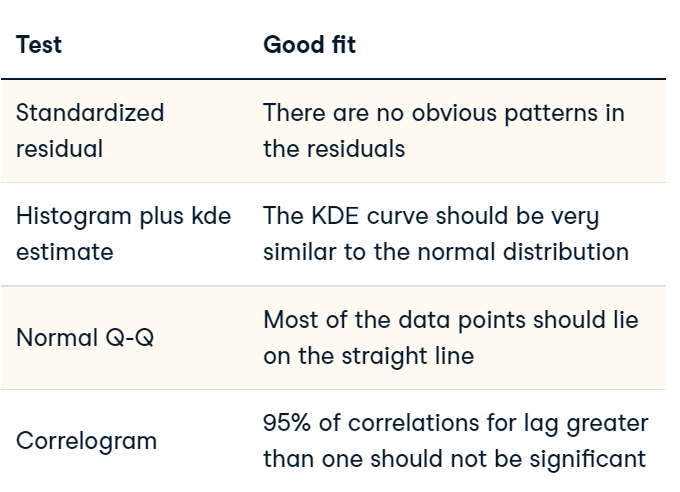

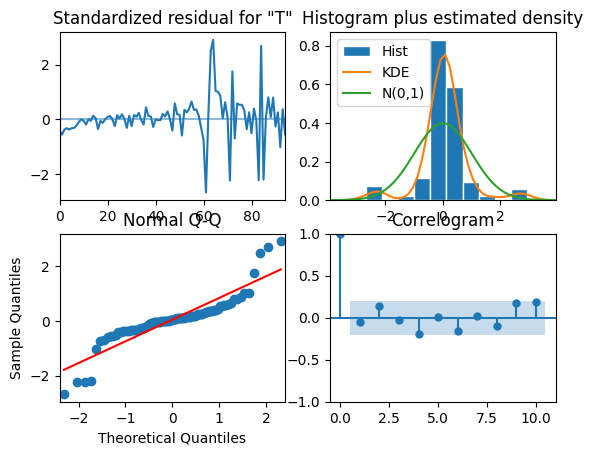

In [69]:
# Create the 4 diagostics plots
model.plot_diagnostics()
plt.show()

In [70]:
forecast_CI = pd.concat([forecast, CI], axis=1)

In [71]:
forecast_CI

,Values,lower_CI,Upper_CI
Feb-23,7.087460e+08,6.599212e+08,7.575707e+08
Mar-23,7.225544e+08,6.661807e+08,7.789281e+08
Apr-23,7.363628e+08,6.719960e+08,8.007297e+08
May-23,7.501713e+08,6.773988e+08,8.229437e+08
Jun-23,7.639797e+08,6.824147e+08,8.455446e+08
Jul-23,7.777881e+08,6.870644e+08,8.685118e+08
Aug-23,7.915965e+08,6.913651e+08,8.918280e+08
Sep-23,8.054050e+08,6.953317e+08,9.154783e+08
Oct-23,8.192134e+08,6.989768e+08,9.394500e+08
Nov-23,8.330218e+08,7.023119e+08,9.637318e+08


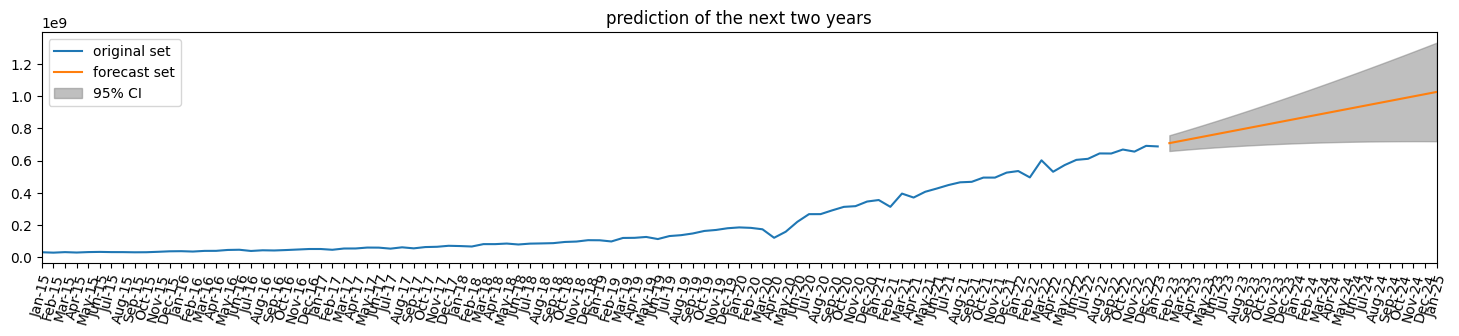

In [85]:
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.plot(clean_POS, label = 'original set')
plt.plot(forecast , label='forecast set')
plt.fill_between(forecast_CI.index, forecast_CI.lower_CI, forecast_CI.Upper_CI, alpha=0.5, color='gray', label='95% CI')
# Set x-axis limits to start from the first date in the data
plt.xlim((clean_POS.index[0], forecast_CI.index[-1]))
plt.xticks(rotation=75)
plt.xticks()
plt.legend()
plt.title('prediction of the next two years')
plt.show() 

<h3> Ponus, trying auto arima function


In [73]:
split_index = int(0.80 * len(clean_POS))
auto_train_data = clean_POS.iloc[:split_index, :]
auto_test_data = clean_POS.iloc[split_index:, :]

In [74]:
auto_model = auto_arima(auto_train_data)

In [104]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1725.838
Date:                Mon, 03 Apr 2023   AIC                           3465.676
Time:                        02:22:59   BIC                           3483.553
Sample:                             0   HQIC                          3472.900
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2983      0.107    -21.394      0.000      -2.509      -2.088
ar.L2         -1.9140      0.145    -13.179      0.000      -2.199      -1.629
ar.L3         -0.5516      0.067     -8.203      0.000      -0.683      -0.420
ma.L1          0.9635      0.120      8.020      0.000       0.728       1.199
ma.L2         -0.7459      0.113     -6.590      0.000      -0.968      -0.524
ma.L3         -0.8740      0.123     -7.077      0.000      -1.116      -0.632
sigma2      3.997e+14   2.96e-16   1.35e+30      0.000       4e+14       4e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               137.76
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              23.97   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+45. Standard errors may be unstable.
"""

In [94]:
auto_y_pred = pd.DataFrame(index= auto_test_data.index)
auto_y_pred['Total'] = auto_model.predict(len(auto_test_data)).values

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [95]:
KPI(y_pred=auto_y_pred, test_data=auto_test_data)

mape = 0.4775918802279192
mae = 261956386.2188283
mse = 6.92498638878541e+16
rmse = 263153688.72173175


In [96]:
auto_model = auto_arima(clean_POS)
auto_y_pred = pd.DataFrame(index= date_index)
auto_y_pred['Total'] = auto_model.predict(len(date_index)).values


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [97]:
auto_y_pred.index = auto_y_pred.index.strftime("%b-%y")

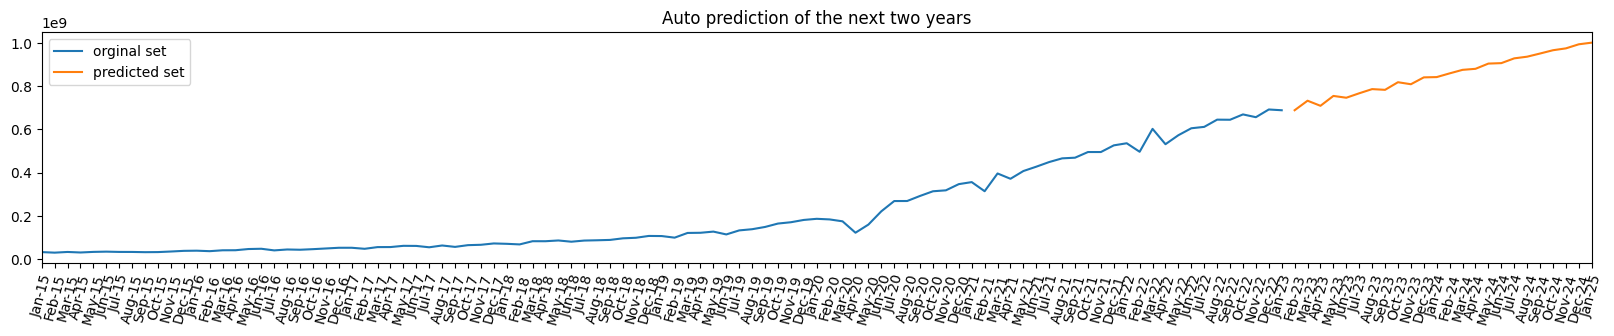

In [105]:
fig = plt.gcf()
fig.set_size_inches(20, 3)
plt.plot(clean_POS, label = 'orginal set')
plt.plot(auto_y_pred.Total, label='predicted set')
plt.xlim((clean_POS.index[0], forecast_CI.index[-1]))
plt.xticks(rotation=75)
plt.title('Auto prediction of the next two years')
plt.legend()
plt.show() 

<h3> let's compare these two models, my model and the auto arima model

In [103]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1735.947
Date:                Mon, 03 Apr 2023   AIC                           3477.893
Time:                        02:22:47   BIC                           3485.555
Sample:                             0   HQIC                          3480.989
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4228      0.087    -16.387      0.000      -1.593      -1.253
ma.L2          0.4819      0.077      6.288      0.000       0.332       0.632
sigma2      6.206e+14        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                98.71
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):              29.16   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+48. Standard errors may be unstable.
"""

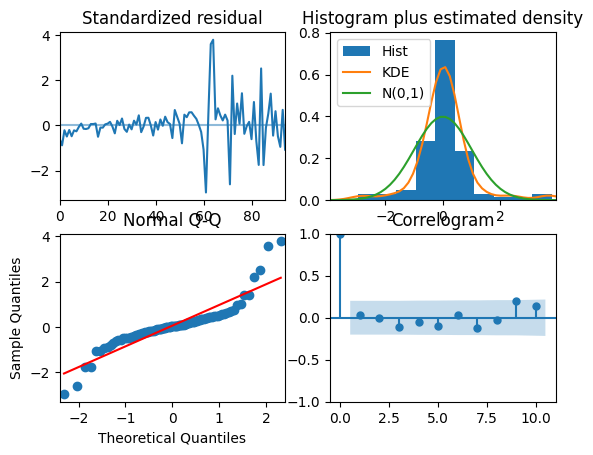

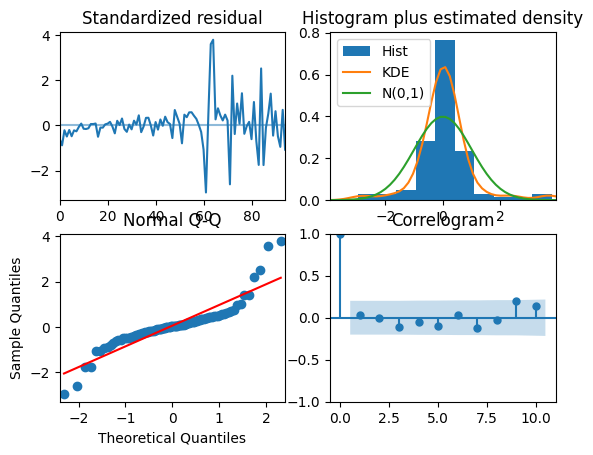

In [99]:
auto_model.plot_diagnostics()